In [59]:
# Built-in modules
import math
import sys
# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [60]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [61]:
def less_than_k(k,user_list):
    #finding the positions of all the inputs that are less than k
    a=max(user_list)
    b=[]
    #converting the postions into binary
    for i in range(len(user_list)):
        if int(user_list[i])<k:
            b.append(i)
    len_list=len(user_list)
    max_bits = len(bin(len_list)[2:])
    if bool(b) ==  False:
        for i in range(len_list):
            print("no smallest no. in the list")
            sys.exit() 
    binary_list=[]
    for num in b:
        binary_num = bin(num)[2:].zfill(max_bits)
        binary_list.append(binary_num)
    marked_states = binary_list
    
    oracle = grover_oracle(marked_states)
    #using a generic backend for simulating the circuit
    backend = GenericBackendV2(
        num_qubits=len_list,
        control_flow=True,
      )
    #using inbuilt Grover operator provided by qiskit
    grover_op = GroverOperator(oracle)
    #no. of iteration would be governed by the length of the initial list
    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    circuit_isa = pm.run(qc)
    circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")
    sampler = Sampler(backend=backend)
    sampler.options.default_shots = 1024
    result = sampler.run([circuit_isa]).result()
    dist = result[0].data.meas.get_counts()
    counts=0
    ans=[]
    #from the dictionray of all the possible values, finding the values whose sum would make more than 85%of the total shots
    for key, value in dist.items():
        counts += value
        ans.append(key)
        if counts / 1024 >= 0.85:
            break
    num=[]
    #to find the no. in the initial list using the positon searched by grover's algorithm
    for i in range(len(ans)):
        binary_num = ans[i]
        decimal_num = int(binary_num, base=2)
        num.append(user_list[decimal_num])

    return num,oracle,qc

[1, 4, 6]
Quantum Circuit:


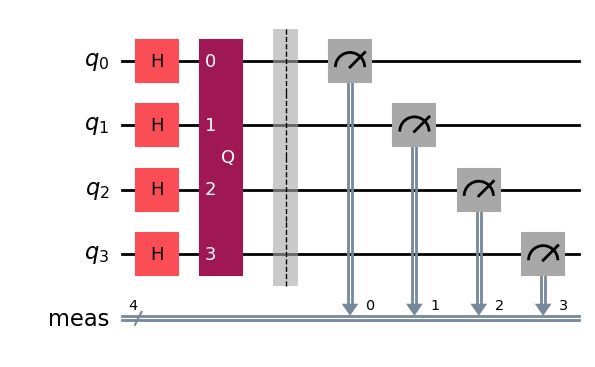

Oracle Circuit:


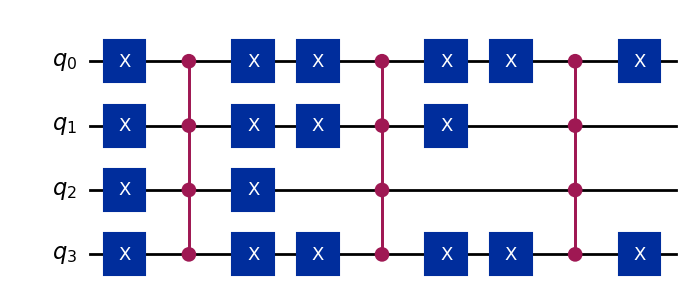

In [63]:
import matplotlib.pyplot as plt
a=[4,9,11,14,1,13,6,15]
b=7
A,oracle,qc= less_than_k(b,a)
print(A)

print('Quantum Circuit:')
display(qc.draw(output='mpl', style='iqp'))

# Display the oracle circuit
print('Oracle Circuit:')
display(oracle.draw(output='mpl', style='iqp'))
